# TASK2
## CREDIT CARD FRAUD DETECTION

Build a model to detect fraudulent credit card transactions. Use a dataset containing information about credit card transactions, and experiment with algorithms like **Logistic Regression, Decision Trees, or Random Forests** to classify transactions as fraudulent or legitimate.

### Data dictionary

1. **Unnamed: 0:** Index.

2. **trans_date_trans_time:** Transaction date and time.

3. **cc_num:** Credit card number.

4. **merchant:** Merchant name.

5. **category:** Merchant category.

6. **amt:** Transaction amount.

7. **first:** Cardholder's first name.

8. **last:** Cardholder's last name.

9. **gender:** Cardholder's gender.

10. **street:** Cardholder's street address.

11. **city:** Cardholder's city.

12. **state:** Cardholder's state.

13. **zip:** Cardholder's zip code.

14. **lat:** Cardholder's latitude.

15. **long:** Cardholder's longitude.

16. **city_pop:** Cardholder's city population.

17. **job:** Cardholder's job.

18. **dob:** Cardholder's date of birth.

19. **trans_num:** Transaction number.

20. **unix_time:** Transaction timestamp in Unix format.

21. **merch_lat:** Merchant's latitude.

22. **merch_long:** Merchant's longitude.

23. **is_fraud:** Fraud indicator (0 = legitimate, 1 = fraudulent).

In [1]:
import pandas as pd
import math
import numpy as np
import scipy.stats as stats
from scipy.stats import binom
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from datetime import datetime


In [3]:
train_data = pd.read_csv("fraudTrain.csv")
test_data = pd.read_csv("fraudTest.csv")

In [4]:
# Concatenate the training and test datasets
combined_data = pd.concat([train_data, test_data], axis=0).reset_index(drop=True)

In [21]:
combined_data.head()

,amt,lat,long,city_pop,is_fraud,age,merchant_fraud_Abbott-Rogahn,merchant_fraud_Abbott-Steuber,merchant_fraud_Abernathy and Sons,merchant_fraud_Abshire PLC,...,job_Visual merchandiser,job_Volunteer coordinator,job_Warden/ranger,job_Warehouse manager,job_Waste management officer,job_Water engineer,job_Water quality scientist,job_Web designer,job_Wellsite geologist,job_Writer
0,-0.408741,-0.485167,0.658263,-0.282429,0,-0.845898,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.233378,2.040531,-2.035415,-0.293527,0,-0.270874,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.942184,0.718034,-1.602731,-0.280243,0,0.649165,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.157381,1.516580,-1.591951,-0.287590,0,0.361653,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.176470,-0.023388,0.783024,-0.293693,0,-0.730894,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
combined_data.shape

(1852394, 2169)

In [31]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Columns: 2169 entries, amt to job_Writer
dtypes: float64(5), int64(1), uint8(2163)
memory usage: 3.8 GB


In [5]:
# Remove irrelevant columns
columns_to_drop = ['trans_date_trans_time', 'Unnamed: 0', 'cc_num', 'zip', 'first', 'last', 'street', 'trans_num', 'merch_lat', 'merch_long', 'unix_time']
columns_to_drop = [col for col in columns_to_drop if col in combined_data.columns]
combined_data = combined_data.drop(columns=columns_to_drop)


In [6]:
# Convert 'dob' to datetime format and calculate age
combined_data['dob'] = pd.to_datetime(combined_data['dob'])
combined_data['age'] = combined_data['dob'].apply(lambda x: datetime.now().year - x.year)
combined_data = combined_data.drop(columns=['dob'])

In [7]:
# Convert categorical variables to numerical using one-hot encoding
combined_data = pd.get_dummies(combined_data, columns=['merchant', 'category', 'gender', 'city', 'state', 'job'])


In [8]:
# Identify numeric features
numeric_features = ['amt', 'lat', 'long', 'city_pop', 'age']

# Create the scaler and apply it only to the numeric features
scaler = StandardScaler()
combined_data[numeric_features] = scaler.fit_transform(combined_data[numeric_features])


In [9]:
# Create a 10% sample of the dataset
sampled_data = combined_data.sample(frac=0.1, random_state=42)


In [10]:
# Separate features and target variable from the sampled dataset
X = sampled_data.drop(columns=['is_fraud'])
y = sampled_data['is_fraud']


In [11]:
# Split the sample dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Concatenate X_train and y_train for undersampling
train_data_bal = pd.concat([X_train, y_train], axis=1)

In [13]:
# Separate majority and minority classes
not_fraud = train_data_bal[train_data_bal['is_fraud'] == 0]
fraud = train_data_bal[train_data_bal['is_fraud'] == 1]

# Undersample the majority class
not_fraud_sampled = not_fraud.sample(n=len(fraud), random_state=42)
balanced_train_data = pd.concat([not_fraud_sampled, fraud])

In [14]:
# Separate features and target variable from the balanced dataset
X_train_balanced = balanced_train_data.drop(columns=['is_fraud'])
y_train_balanced = balanced_train_data['is_fraud']

### Train the Logistic Regression Model

In [15]:
# Train the logistic regression model with the balanced training set
model = LogisticRegression(max_iter=1000)
model.fit(X_train_balanced, y_train_balanced)

LogisticRegression(max_iter=1000)

In [16]:
# Make predictions on the validation set
y_pred = model.predict(X_val)

Accuracy after undersampling: 0.8913031742604189
Confusion Matrix after undersampling:
 [[32869  3985]
 [   42   152]]
Classification Report after undersampling:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94     36854
           1       0.04      0.78      0.07       194

    accuracy                           0.89     37048
   macro avg       0.52      0.84      0.51     37048
weighted avg       0.99      0.89      0.94     37048



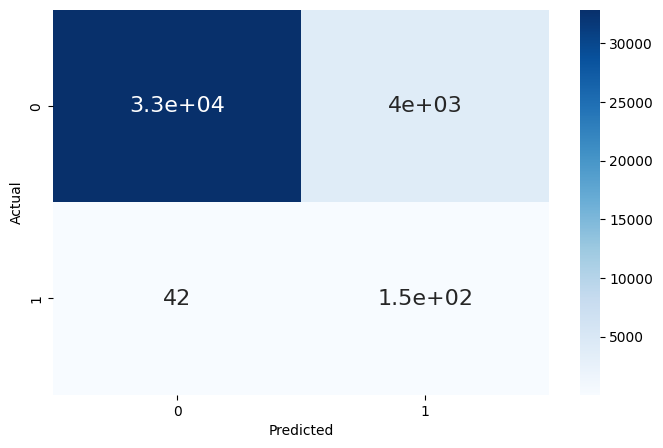

In [17]:
# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)
class_report = classification_report(y_val, y_pred)

# Print results
print("Accuracy after undersampling:", accuracy)
print("Confusion Matrix after undersampling:\n", conf_matrix)
print("Classification Report after undersampling:\n", class_report)

# Visualize the confusion matrix
df_cm = pd.DataFrame(conf_matrix, columns=np.unique(y_val), index=np.unique(y_val))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize=(8, 5))
sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16})  # font size
plt.show()

### Train the Random Forest Model 

In [18]:
# Train the Random Forest model with class weight adjustment
model_rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model_rf.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [19]:
# Make predictions on the validation set
y_pred_rf = model_rf.predict(X_val)

Random Forest model accuracy: 0.9592960483696825
Random Forest Confusion Matrix:
 [[35378  1476]
 [   32   162]]
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     36854
           1       0.10      0.84      0.18       194

    accuracy                           0.96     37048
   macro avg       0.55      0.90      0.58     37048
weighted avg       0.99      0.96      0.97     37048



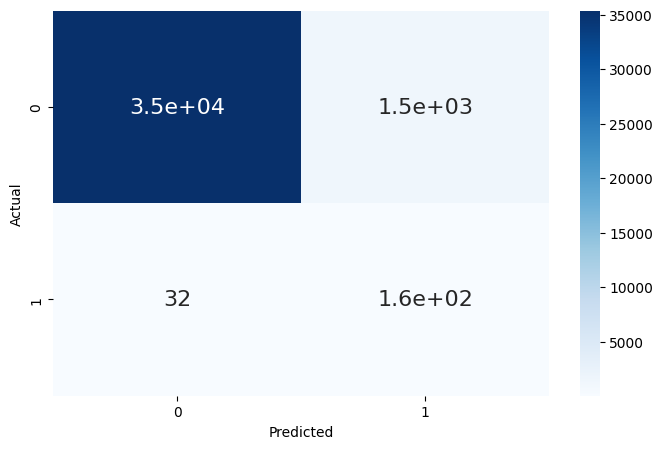

In [20]:
# Evaluate the model
accuracy_rf = accuracy_score(y_val, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_val, y_pred_rf)
class_report_rf = classification_report(y_val, y_pred_rf)

# Print results
print("Random Forest model accuracy:", accuracy_rf)
print("Random Forest Confusion Matrix:\n", conf_matrix_rf)
print("Random Forest Classification Report:\n", class_report_rf)

# Visualize the confusion matrix
df_cm_rf = pd.DataFrame(conf_matrix_rf, columns=np.unique(y_val), index=np.unique(y_val))
df_cm_rf.index.name = 'Actual'
df_cm_rf.columns.name = 'Predicted'
plt.figure(figsize=(8, 5))
sns.heatmap(df_cm_rf, cmap="Blues", annot=True, annot_kws={"size": 16})  # font size
plt.show()

### Conclusion

The Random Forest model clearly outperforms the Logistic Regression model in detecting fraudulent credit cards transaction. Its ability to better handle class imbalance and superior performance in terms of precision and recall make it more suitable for this problem. However, ongoing improvement and model stunning are essential to adapt to new fraud patterns and maintain robus fraud detection capabilities.